In [ ]:
# detect_and_segment.py
import torch
import supervision as sv
from typing import List, Tuple, Optional

# ==== 1. One-time global model loading  =====================================
from utils.florence import (
    load_florence_model,
    run_florence_inference,
    FLORENCE_OPEN_VOCABULARY_DETECTION_TASK
)
from utils.sam import load_sam_image_model, run_sam_inference

from PIL import Image, ImageDraw, ImageColor
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load models once – they stay in memory for repeated calls
FLORENCE_MODEL, FLORENCE_PROC = load_florence_model(device=DEVICE)
SAM_IMAGE_MODEL               = load_sam_image_model(device=DEVICE)

# quick annotators
COLORS          = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700', '#32CD32', '#8A2BE2']
COLOR_PALETTE   = sv.ColorPalette.from_hex(COLORS)
BOX_ANNOTATOR   = sv.BoxAnnotator(color=COLOR_PALETTE, color_lookup=sv.ColorLookup.INDEX)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color=COLOR_PALETTE,
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER_OF_MASS,
    text_color=sv.Color.from_hex("#000000"),
    border_radius=5,
)
MASK_ANNOTATOR  = sv.MaskAnnotator(color=COLOR_PALETTE, color_lookup=sv.ColorLookup.INDEX)

# ==== 2. Inference function  ===============================================

@torch.inference_mode()
@torch.autocast(device_type="cuda", dtype=torch.bfloat16)
def detect_and_segment(
    image          : Image.Image,
    text_prompts   : str | List[str],
    return_image   : bool = True,
) -> Tuple[sv.Detections, Optional[Image.Image]]:
    """
    Run Florence-2 open-vocabulary detection + SAM2 mask refinement on a PIL image.

    Parameters
    ----------
    image : PIL.Image
        Input image in RGB.
    text_prompts : str | List[str]
        Single prompt or comma-separated list (e.g. "dog, tail, leash").
    return_image : bool
        If True, also returns an annotated PIL image.

    Returns
    -------
    detections : sv.Detections
        Supervision object with xyxy, mask, class_id, etc.
    annotated  : PIL.Image | None
        Annotated image (None if return_image=False)
    """
    # Normalize prompt list
    if isinstance(text_prompts, str):
        prompts = [p.strip() for p in text_prompts.split(",") if p.strip()]
    else:
        prompts = [p.strip() for p in text_prompts]

    if len(prompts) == 0:
        raise ValueError("Empty prompt list given.")

    # Collect detections from each prompt
    det_list: list[sv.Detections] = []
    for p in prompts:
        _, result = run_florence_inference(
            model      = FLORENCE_MODEL,
            processor  = FLORENCE_PROC,
            device     = DEVICE,
            image      = image,
            task       = FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
            text       = p,
        )
        det = sv.Detections.from_lmm(
            lmm           = sv.LMM.FLORENCE_2,
            result        = result,
            resolution_wh = image.size,
        )
        det = run_sam_inference(SAM_IMAGE_MODEL, image, det)  # SAM2 refinement
        det_list.append(det)

    detections = sv.Detections.merge(det_list)

    annotated_img = None
    if return_image:
        annotated_img = image.copy()
        annotated_img = MASK_ANNOTATOR.annotate(annotated_img, detections)
        annotated_img = BOX_ANNOTATOR.annotate(annotated_img, detections)
        annotated_img = LABEL_ANNOTATOR.annotate(annotated_img, detections)

    return detections, annotated_img



def fill_detected_bboxes(
    image: Image.Image,
    text: str,
    inflate_pct: float = 0.10,
    fill_color: str | tuple[int, int, int] = "#00FF00",
):
    """
    Detect objects matching `text`, inflate each bounding-box by `inflate_pct`,
    fill the area with `fill_color`, and return the resulting image.

    Parameters
    ----------
    image        : PIL.Image
        Input image (RGB).
    text         : str
        Comma-separated prompt(s) for open-vocabulary detection.
    inflate_pct  : float, default 0.10
        Extra margin per side (0.10 = +10 % width & height).
    fill_color   : str | tuple, default "#00FF00"
        Solid color used to fill each inflated bbox (hex or RGB tuple).

    Returns
    -------
    filled_img   : PIL.Image
        Image with each detected (inflated) box filled.
    detections   : sv.Detections
        Original detection object from `detect_and_segment`.
    """
    # run Florence2 + SAM2 pipeline (your helper from earlier)
    detections, _ = detect_and_segment(image, text)

    w, h = image.size
    filled_img = image.copy()
    draw = ImageDraw.Draw(filled_img)
    fill_rgb = ImageColor.getrgb(fill_color) if isinstance(fill_color, str) else fill_color

    for box in detections.xyxy:
        # xyxy is numpy array → cast to float for math
        x1, y1, x2, y2 = box.astype(float)
        dw, dh = (x2 - x1) * inflate_pct, (y2 - y1) * inflate_pct
        x1_i = max(0, x1 - dw)
        y1_i = max(0, y1 - dh)
        x2_i = min(w, x2 + dw)
        y2_i = min(h, y2 + dh)
        draw.rectangle([x1_i, y1_i, x2_i, y2_i], fill=fill_rgb)

    return filled_img, detections


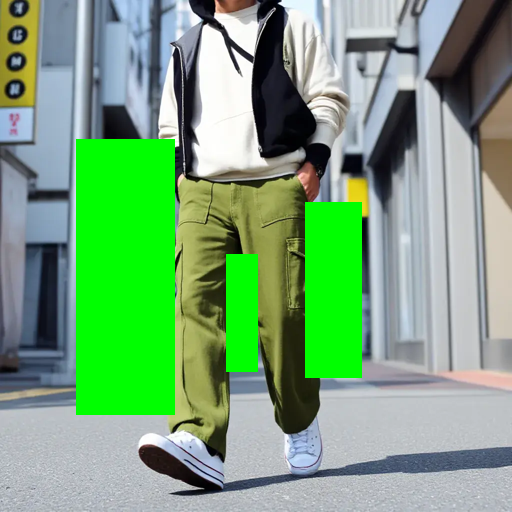

In [ ]:
from PIL import Image

img = Image.open("shoess.webp").resize((512, 512)).convert("RGB")

filled_img, dets = fill_detected_bboxes(
    image       = img,
    text        = "person",
    inflate_pct = 0.15,        # 15 % margin
    fill_color  = "#00FF00"    # chroma green
)

filled_img


In [ ]:
from datasets import load_dataset, Image as HFImage
from pathlib import Path
from tqdm.auto import tqdm
import io, random
from detect_and_segment_v2 import fill_detected_bboxes   # ← your helper

# -------------------------------------------------------
# 1. Config
# -------------------------------------------------------
SOURCE_DATASET   = "beans"           # original dataset
SPLIT            = "train"
TEXT_PROMPT      = "bean leaf"
TARGET_REPO      = "your-username/beans_bbox_filled"  # push destination
INFLATE_MIN, INFLATE_MAX = 0.10, 0.20

# -------------------------------------------------------
# 2. Load dataset locally
# -------------------------------------------------------
ds = load_dataset(SOURCE_DATASET, split=SPLIT, streaming=False)
print("Samples:", len(ds))

# -------------------------------------------------------
# 3. Processing function for .map()
# -------------------------------------------------------
def add_bfill(sample):
    img: HFImage = sample["image"].convert("RGB")

    # random inflate 0.10–0.20
    inflate_pct = random.uniform(INFLATE_MIN, INFLATE_MAX)

    bfilled_img, _ = fill_detected_bboxes(
        image       = img,
        text        = TEXT_PROMPT,
        inflate_pct = inflate_pct,
        fill_color  = "#00FF00",
    )

    # store as raw bytes (Hub-friendly) or leave as PIL
    buf = io.BytesIO()
    bfilled_img.save(buf, format="PNG")
    sample["bbox_filled"] = {"bytes": buf.getvalue(), "path": None}

    return sample

# -------------------------------------------------------
# 4. Map over the dataset (with tqdm progress bar)
# -------------------------------------------------------
ds = ds.map(add_bfill, batched=False, desc="Generating bbox-filled column")

# Tell datasets that `"bbox_filled"` is an image column
ds = ds.cast_column("bbox_filled", HFImage())

# -------------------------------------------------------
# 5. Push back to the Hub
# -------------------------------------------------------
ds.push_to_hub(TARGET_REPO)   # requires you to be logged in (`huggingface-cli login`)


In [9]:
# sequential_furniture_bbox.py
# =============================================================
# Florence-2 + SAM-2 sequential preprocessing (no multiprocessing)
# =============================================================
import os, io, json, random
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
from datasets import load_dataset, Image as HFImage, disable_progress_bar

# --- silence tokenizers fork warning -------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"
disable_progress_bar()

# --- your helper (must be importable) ------------------------

# ==================== CONFIG =================================
DATASET_NAME   = "fotographerai/furniture_shortlisted_batch1_captioned"
SPLIT          = "train"
IMAGE_COL      = "img2"
PROMPT_COL     = "prompt"

INFLATE_RANGE  = (0.10, 0.20)          # 10-20 % expansion
FILL_COLOR     = "#00FF00"             # chroma green
QA_DIR         = Path("bbox_filled_review_seq")
QA_DIR.mkdir(exist_ok=True)

# ==================== LOAD DATASET ============================
ds = load_dataset(DATASET_NAME, split=SPLIT, streaming=False)
print(f"Loaded {len(ds)} rows.")

bbox_filled_col = []
annotated_col   = []
bbox_json_col   = []

# ==================== MAIN LOOP ===============================
for idx, sample in enumerate(tqdm(ds, desc="Processing sequentially")):
    # -- trim prompt before first semicolon --------------------
    prompt_full = sample[PROMPT_COL]
    prompt_trim = prompt_full.split(";", 1)[0].strip()

    img: Image.Image = sample[IMAGE_COL].convert("RGB")
    inflate_pct     = random.uniform(*INFLATE_RANGE)

    # -- generate green-screen & detections --------------------
    try:
        filled_img, detections = fill_detected_bboxes(
            image       = img,
            text        = prompt_trim,
            inflate_pct = inflate_pct,
            fill_color  = FILL_COLOR,
        )
    except:
        continue
    # -- build annotated overlay ------------------------------
    anno = img.copy()
    anno = MASK_ANNOTATOR.annotate(anno, detections)
    anno = BOX_ANNOTATOR.annotate(anno, detections)
    anno = LABEL_ANNOTATOR.annotate(anno, detections)

    # -- save files for manual QA ------------------------------
    filled_path = QA_DIR / f"{idx:05d}_green.png"
    anno_path   = QA_DIR / f"{idx:05d}_anno.png"
    json_path   = QA_DIR / f"{idx:05d}_bbox.json"

    filled_img.save(filled_path)
    anno.save(anno_path)
    with open(json_path, "w") as fp:
        json.dump({"xyxy": detections.xyxy.tolist()}, fp)

    # -- convert images to bytes for dataset -------------------
    def pil2bytes(im: Image.Image) -> dict:
        buf = io.BytesIO()
        im.save(buf, format="PNG")
        return {"bytes": buf.getvalue(), "path": None}

    bbox_filled_col.append(pil2bytes(filled_img))
    annotated_col.append(pil2bytes(anno))
    bbox_json_col.append(json_path.read_text())

# ==================== BUILD NEW DATASET =======================
new_ds = ds.add_column("bbox_filled", bbox_filled_col)
new_ds = new_ds.add_column("annotated",   annotated_col)
new_ds = new_ds.add_column("bbox_json",   bbox_json_col)

new_ds = new_ds.cast_column("bbox_filled", HFImage())
new_ds = new_ds.cast_column("annotated",   HFImage())

print("✅ Done! Review PNG/JSON in:", QA_DIR.resolve())
print("New dataset columns:", new_ds.column_names)

# === (optional) push after manual QA ==========================
# new_ds.push_to_hub("fotographerai/furniture_shortlisted_batch1_bboxfilled")


ERROR! Session/line number was not unique in database. History logging moved to new session 71


Loaded 5764 rows.


Processing sequentially:   0%|          | 0/5764 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# furniture_bbox_fast.py  ────────────────────────────────────────────
# Florence-2 + SAM-2 dataset preprocessing with threaded acceleration
# -------------------------------------------------------------------
import os, io, json, random
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

from tqdm.auto import tqdm
from datasets import load_dataset, Image as HFImage, disable_progress_bar
from PIL import Image

# ── silence HF-tokenizers fork warning ──────────────────────────────
os.environ["TOKENIZERS_PARALLELISM"] = "false"
disable_progress_bar()

# ── import your Florence+SAM helpers  ───────────────────────────────
# assumes detect_and_segment_v2.py & detect_and_segment.py are on PYTHONPATH


# ── CONFIGURATION ───────────────────────────────────────────────────
DATASET_NAME   = "fotographerai/surroundingomnibatch6revised_amr"
SPLIT          = "train"
IMAGE_COL      = "img2"
PROMPT_COL     = "prompt"  # use "prompt" for full prompt text

INFLATE_RANGE  = (0.01, 0.05)          # 10–20 % expansion
FILL_COLOR     = "#00FF00"             # chroma key green
QA_DIR         = Path("bbox_filled_review_fast_batch6")
QA_DIR.mkdir(exist_ok=True)

MAX_WORKERS    = 4                   # threads (tune for your GPU)

# ── load dataset locally ────────────────────────────────────────────
ds = load_dataset(DATASET_NAME, split=SPLIT, streaming=False)
print(f"Loaded {len(ds)} rows.")

# pre-allocate result holders to keep original order
bbox_filled_col = [None] * len(ds)
annotated_col   = [None] * len(ds)
bbox_json_col   = [None] * len(ds)

# ── helper to convert PIL → bytes dict for datasets image column
def pil2bytes(im: Image.Image) -> dict:
    buf = io.BytesIO()
    im.save(buf, format="PNG")
    return {"bytes": buf.getvalue(), "path": None}

# ── thread worker ---------------------------------------------------
def process_row(idx_sample):
    idx, sample = idx_sample
    #prompt_trim = sample[PROMPT_COL].split(";", 1)[0].strip()
    prompt_trim = sample[PROMPT_COL]
    if prompt_trim=="sofas_lazy_chairs":
        prompt_trim = "sofa, lazy chair, armchair"
    elif prompt_trim=="beds":   
        prompt_trim = "bed"
    elif prompt_trim=="desks":
        prompt_trim = "desk"
    elif prompt_trim=="office_chairs":
        prompt_trim = "chair"
    else:
        prompt_trim = sample[PROMPT_COL].split(";", 1)[0].strip()
    img = sample[IMAGE_COL].convert("RGB")

    try:
        filled_img, detections = fill_detected_bboxes(
            image       = img,
            text        = prompt_trim,
            inflate_pct = random.uniform(*INFLATE_RANGE),
            fill_color  = FILL_COLOR,
        )
    except Exception as e:
        print(f"[WARN] idx {idx}: {e}")
        return idx, None, None, None

    # annotated overlay
    anno = img.copy()
    anno = MASK_ANNOTATOR.annotate(anno, detections)
    anno = BOX_ANNOTATOR.annotate(anno, detections)
    anno = LABEL_ANNOTATOR.annotate(anno, detections)

    # local QA files
    filled_path = QA_DIR / f"{idx:05d}_green.png"
    anno_path   = QA_DIR / f"{idx:05d}_anno.png"
    json_path   = QA_DIR / f"{idx:05d}_bbox.json"

    filled_img.save(filled_path)
    anno.save(anno_path)
    with open(json_path, "w") as fp:
        json.dump({"xyxy": detections.xyxy.tolist()}, fp)

    return idx, pil2bytes(filled_img), pil2bytes(anno), json_path.read_text()

# ── threaded execution ----------------------------------------------
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as pool:
    futures = {
        pool.submit(process_row, (i, ds[i])): i
        for i in range(len(ds))
    }

    for fut in tqdm(as_completed(futures),
                    total=len(futures),
                    desc="Threaded Florence+SAM"):
        i, bfill, anno, jtxt = fut.result()
        if bfill is None:            # skipped rows
            continue
        bbox_filled_col[i] = bfill
        annotated_col[i]   = anno
        bbox_json_col[i]   = jtxt

# ── build enriched dataset ------------------------------------------
new_ds = ds.add_column("bbox_filled", bbox_filled_col)
new_ds = new_ds.add_column("annotated",   annotated_col)
new_ds = new_ds.add_column("bbox_json",   bbox_json_col)

new_ds = new_ds.cast_column("bbox_filled", HFImage())
new_ds = new_ds.cast_column("annotated",   HFImage())

print("✅ Completed. Review PNG/JSON in:", QA_DIR.resolve())
print("New dataset columns:", new_ds.column_names)

# optional push after QA
# new_ds.push_to_hub("fotographerai/furniture_shortlisted_batch1_bboxfilled")


Loaded 2700 rows.
[WARN] idx 6: 'NoneType' object is not subscriptable
[WARN] idx 8: 'NoneType' object is not subscriptable
[WARN] idx 12: 'NoneType' object is not subscriptable
[WARN] idx 4: 'NoneType' object is not subscriptable
[WARN] idx 7: 'NoneType' object is not subscriptable
[WARN] idx 11: 'NoneType' object is not subscriptable
[WARN] idx 10: 'NoneType' object is not subscriptable
[WARN] idx 13: 'NoneType' object is not subscriptable
[WARN] idx 16: 'NoneType' object is not subscriptable
[WARN] idx 14: 'NoneType' object is not subscriptable
[WARN] idx 15: 'NoneType' object is not subscriptable
[WARN] idx 17: An image must be set with .set_image(...) before mask prediction.
[WARN] idx 24: 'NoneType' object is not subscriptable
[WARN] idx 46: 'NoneType' object is not subscriptable
[WARN] idx 48: 'NoneType' object is not subscriptable
[WARN] idx 57: 'NoneType' object is not subscriptable
[WARN] idx 64: 'NoneType' object is not subscriptable
[WARN] idx 61: 'NoneType' object is not s

Threaded Florence+SAM:   0%|          | 0/2700 [00:00<?, ?it/s]

[WARN] idx 560: 'NoneType' object is not subscriptable
[WARN] idx 567: 'NoneType' object is not subscriptable
[WARN] idx 578: 'NoneType' object is not subscriptable
[WARN] idx 581: 'NoneType' object is not subscriptable
[WARN] idx 591: 'NoneType' object is not subscriptable
[WARN] idx 598: 'NoneType' object is not subscriptable
[WARN] idx 613: 'NoneType' object is not subscriptable
[WARN] idx 629: 'NoneType' object is not subscriptable
[WARN] idx 635: An image must be set with .set_image(...) before mask prediction.
[WARN] idx 643: 'NoneType' object is not subscriptable
[WARN] idx 647: 'NoneType' object is not subscriptable
[WARN] idx 650: 'NoneType' object is not subscriptable
[WARN] idx 649: An image must be set with .set_image(...) before mask prediction.
[WARN] idx 654: 'NoneType' object is not subscriptable
[WARN] idx 655: 'NoneType' object is not subscriptable
[WARN] idx 657: 'NoneType' object is not subscriptable
[WARN] idx 659: 'NoneType' object is not subscriptable
[WARN] idx 

In [1]:
# furniture_bbox_fast.py  ────────────────────────────────────────────
# Florence-2 + SAM-2 preprocessing with square-padding + auto-retries
# -------------------------------------------------------------------
import os, io, json, random, time
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

from tqdm.auto import tqdm
from datasets import load_dataset, Image as HFImage, disable_progress_bar
from PIL import Image, ImageOps

os.environ["TOKENIZERS_PARALLELISM"] = "false"
disable_progress_bar()

# ═══════════════════ CONFIG ════════════════════════════════════════
DATASET_NAME  = "fotographerai/furniture_captioned_segment_prompt"
SPLIT         = "train"
IMAGE_COL     = "img2"
PROMPT_COL    = "segmenting_prompt"

INFLATE_RANGE = (0.01, 0.05)
FILL_COLOR    = "#00FF00"

QA_DIR        = Path("bbox_review_recaptioned"); QA_DIR.mkdir(exist_ok=True)
MAX_WORKERS   = 4
MAX_RETRIES   = 3
RETRY_SLEEP   = 0.3          # seconds between retries
TARGET_SIDE   = 1500         # final square size (px)

FAILED_LOG    = QA_DIR / "failed_rows.jsonl"

# ═══════════════════ LOAD DATA ═════════════════════════════════════
ds = load_dataset(DATASET_NAME, split=SPLIT, streaming=False)
print("Rows:", len(ds))

filled_col, anno_col, json_col = [None]*len(ds), [None]*len(ds), [None]*len(ds)

def pil2bytes(im: Image.Image):
    buf = io.BytesIO(); im.save(buf, format="PNG"); buf.seek(0)
    return {"bytes": buf.getvalue(), "path": None}

# map some categories → explicit prompts
PROMPT_MAP = {

}

# pad & resize to TARGET_SIDE × TARGET_SIDE
def make_square(im: Image.Image, side: int = TARGET_SIDE) -> Image.Image:
    # keep aspect ratio, add padding to reach 'side'
    im = ImageOps.contain(im, (side, side))          # resize w/ ratio
    pad_w = side - im.width
    pad_h = side - im.height
    # center pad with reflection to avoid solid borders that might confuse model
    im = ImageOps.expand(im,
                         border=(pad_w//2, pad_h//2,
                                 pad_w - pad_w//2, pad_h - pad_h//2),
                         fill=im.getpixel((0,0)))
    return im

# ── worker with square-padding + retries ───────────────────────────
def process_row(i, sample):
    prompt = PROMPT_MAP.get(sample[PROMPT_COL],
                            sample[PROMPT_COL].split(",", 1)[0].strip())
    img0   = sample[IMAGE_COL].convert("RGB")
    img_sq = make_square(img0)
    
    print(f"Processing idx {i}: {prompt} ({img_sq.size[0]}x{img_sq.size[1]})")

    for attempt in range(1, MAX_RETRIES+1):
        try:
            filled, dets = fill_detected_bboxes(
                image       = img_sq,
                text        = prompt,
                inflate_pct = random.uniform(*INFLATE_RANGE),
                fill_color  = FILL_COLOR,
            )
            if dets is None or len(dets.xyxy) == 0:
                raise ValueError("no detections")

            anno = img_sq.copy()
            anno = MASK_ANNOTATOR.annotate(anno, dets)
            anno = BOX_ANNOTATOR.annotate(anno, dets)
            anno = LABEL_ANNOTATOR.annotate(anno, dets)

            # QA artefacts
            filled.save(QA_DIR / f"{i:06d}_green.png")
            anno  .save(QA_DIR / f"{i:06d}_anno.png")
            bbox_path = QA_DIR / f"{i:06d}_bbox.json"
            bbox_path.write_text(json.dumps({"xyxy": dets.xyxy.tolist()}))

            return ("ok", pil2bytes(filled), pil2bytes(anno),
                    bbox_path.read_text())

        except Exception as e:
            print(f"[WARN] idx {i} try {attempt}/{MAX_RETRIES}: {e}")
            if attempt < MAX_RETRIES:
                time.sleep(RETRY_SLEEP)
            else:
                return ("fail", str(e))

# ═══════════════════ THREAD POOL ═══════════════════════════════════
fails = 0
with ThreadPoolExecutor(MAX_WORKERS) as pool:
    fut2idx = {pool.submit(process_row, i, ds[i]): i for i in range(len(ds))}
    for fut in tqdm(as_completed(fut2idx), total=len(fut2idx),
                    desc="Florence+SAM"):
        i = fut2idx[fut]
        result = fut.result()
        if result[0] == "ok":
            _, bfill, anno, jtxt = result
            filled_col[i], anno_col[i], json_col[i] = bfill, anno, jtxt
        else:
            fails += 1
            with FAILED_LOG.open("a") as fp:
                fp.write(json.dumps({"idx": i, "reason": result[1]})+"\n")

print(f"❌ permanently failed rows: {fails}")

# ═══════════════════ BUILD SUCCESS DATASET ═════════════════════════
keep = [i for i,x in enumerate(filled_col) if x is not None]
new_ds = ds.select(keep)
new_ds = new_ds.add_column("bbox_filled", [filled_col[i] for i in keep])
new_ds = new_ds.add_column("annotated",   [anno_col[i]   for i in keep])
new_ds = new_ds.add_column("bbox_json",   [json_col[i]   for i in keep])
new_ds = new_ds.cast_column("bbox_filled", HFImage())
new_ds = new_ds.cast_column("annotated",   HFImage())

print(f"✅ successes: {len(new_ds)} / {len(ds)}")
print("QA artefacts in:", QA_DIR.resolve())
print("Columns:", new_ds.column_names)

# new_ds.push_to_hub("fotographerai/surround_omnibatch6_bboxfilled")


Rows: 5760
Processing idx 0: Sofa (1500x1500)
[WARN] idx 0 try 1/3: name 'fill_detected_bboxes' is not defined
Processing idx 1: Sofa (1500x1500)
[WARN] idx 1 try 1/3: name 'fill_detected_bboxes' is not defined
Processing idx 2: Sofa (1500x1500)
[WARN] idx 2 try 1/3: name 'fill_detected_bboxes' is not defined
Processing idx 3: Couch (1500x1500)
[WARN] idx 3 try 1/3: name 'fill_detected_bboxes' is not defined
[WARN] idx 0 try 2/3: name 'fill_detected_bboxes' is not defined
[WARN] idx 1 try 2/3: name 'fill_detected_bboxes' is not defined
[WARN] idx 2 try 2/3: name 'fill_detected_bboxes' is not defined
[WARN] idx 3 try 2/3: name 'fill_detected_bboxes' is not defined
[WARN] idx 0 try 3/3: name 'fill_detected_bboxes' is not defined
[WARN] idx 1 try 3/3: name 'fill_detected_bboxes' is not defined
[WARN] idx 2 try 3/3: name 'fill_detected_bboxes' is not defined
Processing idx 4: Couch (1500x1500)
[WARN] idx 4 try 1/3: name 'fill_detected_bboxes' is not defined
[WARN] idx 3 try 3/3: name 'fill

KeyboardInterrupt: 

In [ ]:
"""
reassemble_bbox_dataset.py
Re-build bbox_filled / annotated / bbox_json columns from QA folder.
Missing rows receive a 1500×1500 green mask & full-frame bbox.
"""
from pathlib import Path
import json, io, os
from tqdm.auto import tqdm
from datasets import load_dataset, Dataset, Image as HFImage
from PIL import Image

# ═════ CONFIG ═══════════════════════════════════════════════════════
DATASET_NAME  = "fotographerai/furniture_captioned_segment_prompt"
SPLIT         = "train"
IMAGE_COL     = "img2"            # keep original image column(s)
ID_COL        = "id"              # unique identifier, or use row index
QA_DIR        = Path("bbox_review_recaptioned")   # where *_green.png live
TARGET_SIDE   = 1500
GREEN_RGB     = (0, 255, 0)

# ═════ LOAD ORIGINAL DATASET (no internet after first cache) ════════
ds = load_dataset(DATASET_NAME, split=SPLIT, streaming=False)
print("Original rows:", len(ds))

# ═════ HELPERS ══════════════════════════════════════════════════════
def img_ref(path: Path):
    """Return datasets “image” dict referring to a file on disk."""
    return {"path": str(path), "bytes": None}

def make_green_mask(path: Path, side: int = TARGET_SIDE):
    """Create and save a solid-green PNG mask."""
    if not path.exists():
        img = Image.new("RGB", (side, side), GREEN_RGB)
        img.save(path)

def full_bbox_json(path: Path, side: int = TARGET_SIDE):
    if not path.exists():
        with open(path, "w") as fp:
            json.dump({"xyxy": [[0, 0, side, side]]}, fp)

# ═════ BUILD RECORDS LIST ═══════════════════════════════════════════
records = []
for i in tqdm(range(len(ds)), desc="Re-assembling"):
    # file paths for this row
    green_png = QA_DIR / f"{i:06d}_green.png"
    anno_png  = QA_DIR / f"{i:06d}_anno.png"
    bbox_js   = QA_DIR / f"{i:06d}_bbox.json"

    if not green_png.exists() or not anno_png.exists() or not bbox_js.exists():
        # create fallback artefacts
        mask_png = QA_DIR / f"{i:06d}_mask.png"
        make_green_mask(mask_png)
        green_png = anno_png = mask_png
        full_bbox_json(bbox_js)

    records.append({
        **{k: ds[i][k] for k in ds[i].keys()},   # copy original cols
        "bbox_filled": img_ref(green_png),
        "annotated"  : img_ref(anno_png),
        "bbox_json"  : bbox_js.read_text(),
    })

# ═════ DATASET FROM LIST ════════════════════════════════════════════
new_ds = Dataset.from_list(records)
new_ds = new_ds.cast_column("bbox_filled", HFImage())
new_ds = new_ds.cast_column("annotated",   HFImage())

print("✅ rebuilt rows:", len(new_ds))
print("Columns:", new_ds.column_names)

# (optional) push
# new_ds.push_to_hub("fotographerai/furniture_bboxfilled_rebuild")


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

Original rows: 5760


Re-assembling:   0%|          | 0/5760 [00:00<?, ?it/s]

In [2]:
#!/usr/bin/env python
"""
sample_per_category.py  ────────────────────────────────────────────────
Sample K images per category from a Hugging Face dataset (local or hub).

• Keeps original rows intact (no re-export of PNG bytes).
• Produces:
      ├─ sample_manifest.csv   # (dataset_idx, category, image_path …)
      └─ sampled_images/       # (optional) hard-linked / copied PNGs

Adjust the CONFIG section and run.
"""
import random, csv, shutil
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm
from datasets import load_dataset, Dataset, disable_progress_bar

disable_progress_bar()

# ═════ CONFIG ─────────────────────────────────────────────────══════
DATASET_ID      = "fotographerai/furniture_bboxfilled_rebuild"  # hub path OR local dir
SPLIT           = "train"
CATEGORY_COL    = "category"        # e.g. "category"  (string)
IMAGE_COL       = "annotated"     # column to copy (HF image type or path dict)
K_PER_CATEGORY  = 3                 # how many to sample
OUTPUT_DIR      = Path("sampled_images")    # set None to skip copying
MANIFEST_CSV    = Path("sample_manifest.csv")
SEED            = 42
COPY_METHOD     = "link"            # "link", "copy" or "symlink"
# ════════════════════════════════════════════════════════════════════

random.seed(SEED)
ds = load_dataset(DATASET_ID, split=SPLIT, streaming=False)
print(f"Loaded {len(ds)} rows from {DATASET_ID}[{SPLIT}]")

# ── group indices by category ───────────────────────────────────────
by_cat: dict[str, list[int]] = defaultdict(list)
for idx, row in enumerate(tqdm(ds, desc="Indexing")):
    by_cat[row[CATEGORY_COL]].append(idx)

print("Categories:", len(by_cat))

# ── sample -------------------------------------------------------------------
samples: list[tuple[int,dict]] = []      # (row_idx, row_dict)
for cat, idxs in by_cat.items():
    chosen = random.sample(idxs, min(K_PER_CATEGORY, len(idxs)))
    for i in chosen:
        samples.append((i, ds[i]))

print(f"Total sampled rows: {len(samples)}")

# ── optional: copy images -----------------------------------------------------
if OUTPUT_DIR:
    OUTPUT_DIR.mkdir(exist_ok=True)
    for row_idx, row in tqdm(samples, desc="Copying images"):
        src_info = row[IMAGE_COL]
        # src_info may already be {"path": …} or full Image object; handle both
        src_path = src_info["path"] if isinstance(src_info, dict) else src_info
        dst_path = OUTPUT_DIR / f"{row_idx:06d}_{Path(src_path).name}"
        if COPY_METHOD == "link":
            dst_path.hardlink_to(src_path) if not dst_path.exists() else None
        elif COPY_METHOD == "symlink":
            dst_path.symlink_to(src_path)   if not dst_path.exists() else None
        else:  # "copy"
            shutil.copy2(src_path, dst_path)

# ── write CSV manifest --------------------------------------------------------
with MANIFEST_CSV.open("w", newline="") as fp:
    writer = csv.writer(fp)
    writer.writerow(["row_idx", CATEGORY_COL, "image_path"])
    for idx, row in samples:
        img_path = row[IMAGE_COL]["path"] if isinstance(row[IMAGE_COL], dict) else row[IMAGE_COL]
        writer.writerow([idx, row[CATEGORY_COL], img_path])

print(f"✅ Manifest written to {MANIFEST_CSV.resolve()}")
if OUTPUT_DIR:
    print(f"📂 Images saved / linked in {OUTPUT_DIR.resolve()}")


train-00000-of-00046.parquet:   0%|          | 0.00/587M [00:00<?, ?B/s]

train-00001-of-00046.parquet:   0%|          | 0.00/626M [00:00<?, ?B/s]

train-00002-of-00046.parquet:   0%|          | 0.00/555M [00:00<?, ?B/s]

train-00003-of-00046.parquet:   0%|          | 0.00/619M [00:00<?, ?B/s]

train-00004-of-00046.parquet:   0%|          | 0.00/637M [00:00<?, ?B/s]

train-00005-of-00046.parquet:   0%|          | 0.00/583M [00:00<?, ?B/s]

train-00006-of-00046.parquet:   0%|          | 0.00/559M [00:00<?, ?B/s]

train-00007-of-00046.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

train-00008-of-00046.parquet:   0%|          | 0.00/294M [00:00<?, ?B/s]

train-00009-of-00046.parquet:   0%|          | 0.00/354M [00:00<?, ?B/s]

train-00010-of-00046.parquet:   0%|          | 0.00/362M [00:00<?, ?B/s]

train-00011-of-00046.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

train-00012-of-00046.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

train-00013-of-00046.parquet:   0%|          | 0.00/528M [00:00<?, ?B/s]

train-00014-of-00046.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00015-of-00046.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00016-of-00046.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00017-of-00046.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00018-of-00046.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00019-of-00046.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00020-of-00046.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00021-of-00046.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00022-of-00046.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00023-of-00046.parquet:   0%|          | 0.00/503M [00:00<?, ?B/s]

train-00024-of-00046.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00025-of-00046.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00026-of-00046.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00027-of-00046.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

train-00028-of-00046.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

train-00029-of-00046.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00030-of-00046.parquet:   0%|          | 0.00/435M [00:00<?, ?B/s]

train-00031-of-00046.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

train-00032-of-00046.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

train-00033-of-00046.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

train-00034-of-00046.parquet:   0%|          | 0.00/582M [00:00<?, ?B/s]

train-00035-of-00046.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00036-of-00046.parquet:   0%|          | 0.00/609M [00:00<?, ?B/s]

train-00037-of-00046.parquet:   0%|          | 0.00/412M [00:00<?, ?B/s]

train-00038-of-00046.parquet:   0%|          | 0.00/411M [00:00<?, ?B/s]

train-00039-of-00046.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

train-00040-of-00046.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

train-00041-of-00046.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00042-of-00046.parquet:   0%|          | 0.00/673M [00:00<?, ?B/s]

train-00043-of-00046.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

train-00044-of-00046.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00045-of-00046.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

Loaded 5760 rows from fotographerai/furniture_bboxfilled_rebuild[train]


Indexing:   0%|          | 0/5760 [00:00<?, ?it/s]

Categories: 21
Total sampled rows: 63


Copying images:   0%|          | 0/63 [00:00<?, ?it/s]

TypeError: expected str, bytes or os.PathLike object, not PngImageFile

In [3]:
# ds is the Dataset you've loaded
categories: list[str] = sorted(set(ds["category"]))   # or whatever your column is called
print(f"{len(categories)} unique categories:\n", categories)


21 unique categories:
 ['Furniture_Interior_batch3', 'Furniture_nordic_nest', 'Illumination_nordic_nest', 'Interior_goods', 'Interior_nordic_nest', 'Kitchen_bathroom', 'Tableware', 'beds', 'castlery-Accessories', 'castlery-Beds', 'castlery-Chairs', 'castlery-Furniture Sets', 'castlery-Outdoor Furniture', 'castlery-Sofas', 'castlery-Storage', 'castlery-Tables', 'decoration-vase_batch3', 'desks', 'lamps_chandeliers_batch2', 'office_chairs', 'sofas_lazy_chairs']
